TODO:
- Сформировать из 27 млн подвыборку 100 000
- Сформировать обучающию выборку
- Кластеризовать
- Найти самые популярные товары в каждом кластере
- Для пользователей каждого кластера порекомендовать товары которые популярны внутри кластеров но не куплены ими
- Попытаться сделать для всех 27 млн

In [1]:
PATH_TO_DATA="/Users/roman/Data_Saints/data/X5/"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

from sklearn.cluster import k_means,KMeans
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder,normalize
from sklearn.metrics.pairwise import pairwise_distances

from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, SpectralClustering

________

In [2]:
data=pd.read_csv(PATH_TO_DATA+"X5.csv",sep=";")
data.head(2)

,USER_ID,DT,PLU,QTY,ORDER_ID
0,1,03.06.16,3456173,1,1
1,1,03.06.16,6178,"0,24",1


In [3]:
#Явных пропусков нет(хотя возможно есть заглушка)
data.isnull().any().any()

False

### Train and Test

In [4]:
train=data[:100000]

### Формирование обучающей выборки

In [5]:
train.head(2)

,USER_ID,DT,PLU,QTY,ORDER_ID
0,1,03.06.16,3456173,1,1
1,1,03.06.16,6178,"0,24",1


In [6]:
train.drop(["DT","QTY"],axis=1,inplace=True)

/Users/roman/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [7]:
train.head(2)

,USER_ID,PLU,ORDER_ID
0,1,3456173,1
1,1,6178,1


In [8]:
#OHE

OHE=pd.get_dummies(train.PLU,prefix="PLU")
columns_OHE=list(OHE.columns)

#np.concatenate быстрее
OHE=OHE.as_matrix()
train_OHE=train.drop("PLU",axis=1).as_matrix()

train_row=np.concatenate([train_OHE,OHE],axis=1)

train_OHE=pd.DataFrame(train_row,columns=["USER_ID","ORDER_ID"]+columns_OHE)
train_OHE.head(2)

,USER_ID,ORDER_ID,PLU_47,PLU_54,PLU_88,PLU_114,PLU_126,PLU_194,PLU_212,PLU_261,...,PLU_78005806,PLU_78005825,PLU_78005827,PLU_78005836,PLU_78005837,PLU_78005845,PLU_78006038,PLU_78006057,PLU_78006119,PLU_78006124
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
train_drop_PLU=train.drop("PLU",axis=1)
num_purc=pd.pivot_table(train_drop_PLU,index="USER_ID",aggfunc="max")["ORDER_ID"]

In [10]:
%%time
#ОЧЕНЬ ДОЛГО(на 100 000)
df=pd.pivot_table(train_OHE,index=["USER_ID"],aggfunc=np.sum)
df["ORDER_ID"]=num_purc

df.head(2)

CPU times: user 20.5 s, sys: 40.6 s, total: 1min 1s
Wall time: 1min 26s


### Кластеризация

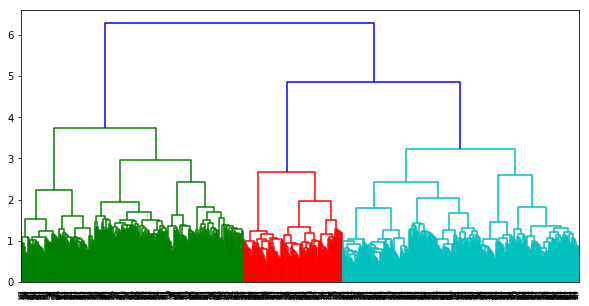

In [11]:
distance_mat = pdist(normalize(df)) # pdist посчитает нам верхний треугольник матрицы попарных расстояний
                            
Z = hierarchy.linkage(distance_mat,method="ward") # linkage — реализация агломеративного алгоритма
plt.figure(figsize=(10, 5))
dn = hierarchy.dendrogram(Z)

Widget Javascript not detected.  It may not be installed or enabled properly.


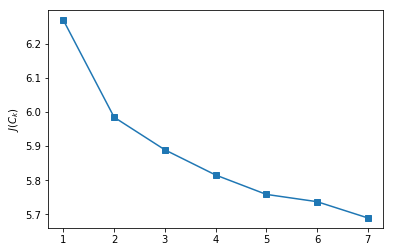

In [12]:
inertia = []
for k in tqdm(range(1, 8)):
    kmeans = KMeans(n_clusters=k, random_state=17).fit(normalize(df,norm="l1"))
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 8), inertia, marker='s');
plt.ylabel('$J(C_k)$');

___________________

**Вывод**:
- Основываясь на дендрограмме варда и методе локтя оптимальное кол-во кластеров **3**
- Силует показал что метод **kmeans** лучше AgglomerativeClustering

Дальнейшая модель будет строиться на:
- 3 кластерах
- Нормализованных данных (норма L1)
- Методом kmeans

### Поиск самых популярных товаров в каждом кластере

In [13]:
#Распределение классов
kmeans=KMeans(n_clusters=3, random_state=17).fit(normalize(df,norm="l1"))    
pd.Series(kmeans.labels_).value_counts()

1    510
2    261
0     93
dtype: int64

In [14]:
df["class"]=kmeans.labels_

In [15]:
#Предсказание самых популярныйх товаров в каждом классе (по хорошему нужно бы по времени еще)
goods=pd.pivot_table(df,index="class",aggfunc="sum")
goods

,ORDER_ID,PLU_10003,PLU_10004,PLU_10019,PLU_10036,PLU_10087,PLU_10126,PLU_10147,PLU_10168,PLU_10170,...,PLU_99277,PLU_99330,PLU_99517,PLU_99556,PLU_99557,PLU_9966,PLU_99710,PLU_99768,PLU_99850,PLU_9994
class,,,,,,,,,,,,,,,,,,,,,
0,998,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7599,4,2,5,2,1,128,1,40,4,...,1,1,2,1,2,5,4,0,6,1
2,4370,0,0,1,0,0,45,2,6,0,...,0,0,0,0,0,0,2,2,0,1


In [16]:
#N самых популярных товаров в каждом кластере
n_goods=10
n_class=3
clasters=[]
for n in range(n_class):
    clasters.append(goods[goods.index==n].T.sort_values(by=n,ascending=False).drop("ORDER_ID")[n][:n_goods])

### Для каждого клиента в своем кластере рекомендация популярных(но ренее не покупаемых) товаров

In [17]:
n_class=3
result={}
for n in tqdm(range(n_class)):
    num_row=df[df["class"]==n].shape[0]
    for i in range(num_row):
        tmp=df[df["class"]==n][clasters[n].keys()].iloc[i,:]==0
        num=tmp.name
        values=df[df["class"]==n][clasters[n].keys()].iloc[i,:][tmp].keys()
        result[num]=list(values)
    

Widget Javascript not detected.  It may not be installed or enabled properly.


In [18]:
result_visual={}
for i in result:
    result_visual[i]=len(result[i])

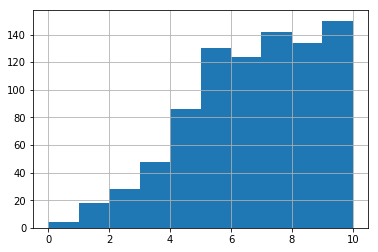

In [19]:
pd.Series(result_visual).hist();

In [20]:
edge=4 #Выше скольки товаров не некомендовать(если из 10 нужно порекомендовать 6 то возможно что не стоит вообще)
result2=pd.Series(result).apply(lambda x: np.NaN if len(x)>edge or len(x)==0 else x)
result2_final=result2.dropna()
len(result2_final)

180

## Итого

Из **864** клиентов нашлось найти **180**, которым можно порекомендовать товар который они скорее всего купят